## Find the stars in your dataset

Given a **dataframe with aggregate data** (that is, the entities (Eg. players) should have one row each. If there are multiple rows to an entity, say one per year, then the report will not be meaningful..) and a **list of categories of interest, report top 5 (default) entities based on the number of categories in which they rank within the top 5 (default N=5).**

Note that the table is giving the rank in each category and the **overall rank based on normalized ranks within this table** (i.e., <font color='blue'>within the table, in the 3P% category, 1=>1, 3=>2, 104=>3 and in FT%, 1=>1, 77=>2, 106=>3, etc</font>)

```
df_stars( wnba, ['FG%', '3P%', 'FT%'])

                  FG%  3P%  FT%  Final
Crystal Langhorne   2    3  106      1
Angel Robinson      9    1    1      2
Sylvia Fowles       3  104   77      3
Aneika Henry        1  104  139      4
Brittany Boyd       4  104  104      5
```

Ideally, we would like to generate an interactive table that looks like this, where one can click or hover on a cell to get the value (rank displayed by default)


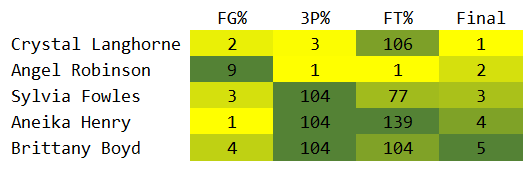
#### If you figure out a way, please share :)
Also, would be nice to know how to get this embedded image aligned left rather than center (with HTML, easy, but then, how does one embed it?)

### Features :
* Function automatically figures out the "Name" column (the non-numeric one with largest number of unique elements)  
* No cleaning necessary for numeric columns (which are read in as strings because of outliers, etc)  
* Find stars or rogues - by default, it fetches entities with the highest values in the categories of interest, but the report_max flag can be set to False to fetch the "least bad" (for example, the best players going by turnovers would have the lowest scores in the TO column)

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
wnba = pd.read_csv('WNBA Stats.csv') # https://www.kaggle.com/jinxbe/wnba-player-stats-2017
wnba.head(2)

,Name,Team,Pos,Height,Weight,BMI,Birth_Place,Birthdate,Age,College,...,OREB,DREB,REB,AST,STL,BLK,TO,PTS,DD2,TD3
0,Aerial Powers,DAL,F,183,71.0,21.200991,US,"January 17, 1994",23,Michigan State,...,6,22,28,12,3,6,12,93,0,0
1,Alana Beard,LA,G/F,185,73.0,21.329438,US,"May 14, 1982",35,Duke,...,19,82,101,72,63,13,40,217,0,0


In [3]:
def get_col_tops( df, nameCol, col, N=5, highest=True ) :
    """ DataFrame, string, string, int --> list of strings"""
    # when dataframe is arranged by column col, what are the names in nameCol 
    # corresponding to the top N in column col
    count = 0
    names = []
    for val in sorted(df[col].unique(),reverse=highest)[:N] :
        stars = df.loc[ df[col] == val, nameCol]
        count += len( stars )
        names.extend(stars.to_list() )
        if count >= N :
            break
    return names

In [4]:
def get_ID_col( df_in ) :
    """ DataFrame --> string"""
    # return name of the non-numeric column with the highest diversity
    # we do crude checking to see if the column is actually numeric to handle unclean data
    # that is, a truly numeric column with many unique values is read in as string (object) because
    # of a few non-numeric values
    df = df_in.copy()
    name_col = None
    nn_count = 0
    for col in df.select_dtypes( include='object').columns :
        df[col] = df[col].str.replace('[$, ]', '')
        non_num = df.loc[ ~df[col].str.match( pat='^[+-]?(\d+|\d*\.\d+|\d+\.\d*)([eE][-+]?[0-9]+)?$'), col].unique()
        if len( non_num ) > nn_count :
            nn_count = len( non_num )
            name_col = col
    return name_col

In [5]:
def clean_numeric_col( series ) :
    """pd.Series --> pd.Series"""
    if pd.api.types.is_numeric_dtype( series ) :
        return series
    ser = series.str.replace('[$, ]', '')
    temp = ser.copy()
    temp[ ~temp.str.match( pat='^[+-]?(\d+|\d*\.\d+|\d+\.\d*)([eE][-+]?[0-9]+)?$')] = np.NaN
    temp = temp.astype('float')
    non_num = ser[ ~ser.str.match( pat='^[+-]?(\d+|\d*\.\d+|\d+\.\d*)([eE][-+]?[0-9]+)?$')].unique()
    if len( non_num ) == 1 and temp.min() > 0 and re.match( '^\w+$', non_num[0] ) :
        ser = ser.str.replace( non_num[0], '0' )    # replace the singleton if other values are > 0
                                            # and uses only word characters (not specials like ?)
        ser = ser.astype('float')
    else :
        ser = temp  # since this already has the non-numeric replaced with NaN
    return ser

In [6]:
def rank_in_col( df_in, col, nameCol, name, reverse=False, cleaned=False ) :
    """ DataFrame, string, string, string, bool, bool--> int"""
    # A,B,C,D in 10,10,5,7 => D's rank is 3 since there are two ahead of it
    if cleaned :
        df = df_in
    else :
        df = df_in.copy()
        df[col] = clean_numeric_col( df[col] )
    if reverse :
        return 1 + df.loc[ df[col] < df.loc[df[nameCol] == name,col ].iloc[0] ].shape[0]
    else :
        return 1 + df.loc[ df[col] > df.loc[df[nameCol] == name,col ].iloc[0] ].shape[0]

In [17]:
def df_stars( df_in, categories, name=None, N=5, report_max=True , weights=None ) :
    """ dataframe, list of strings, string,int, string --> dataframe and printed report """
    # name : the column whose values you want in the final report (Eg. 'Name' in the WNBA dataset)
    # - by default, the column with the most unique non-numeric values will be used
    # N : how many top items in each category to consider
    # categories - the numeric data columns to be used to find the stars Eg : ['PTS', 'FG%']
    #       need not be cleaned. If a category has too many non-numeric items (more than pc_discard%) the it's dropped
    # report_max : if True, then the "tops" in each category are the highest numbers, else the lowest
    # weights (not implemented yet)
    #  : by default, each category has equal weight with the order of the categories counting
    #        : to break ties. That is, if in cats 1,2,3,4 players A and B have identical values in 2,3 and 4
    #        :     then the score in cat 1 will be used to break the tie to rank one player ahead of the other
    #        :   in the final report. But, if weights are specified, (default, all equal weight, with order considered)
    #        :   then, if cat 1 is weighted 2, while others are 1, then if player A achieves rank 1 in cat 1
    #        :   but does not figure in cats 2,3,4, he may still place higher than player B who is lower in cat 1
    #        :   but makes the top 5 in cats 2,3,4
    # summary : stars are the ones making the top-N in the largest number of categories of interest
    if name is None :
        name = get_ID_col( df_in )
    df = df_in.copy()
    tops = pd.DataFrame( columns=['memberships'])
    for col in categories :
        df[col] = clean_numeric_col( df[col] )
        # here, need to clean the column by discarding NaN. Is that necessary though? Since we're only looking
        # at ranks?
        names_in_col = get_col_tops( df, name, col, N, highest=report_max )
        for entity in names_in_col :
            if entity not in tops.index :
                tops.loc[ entity, 'memberships'] = 1
            else :
                tops.loc[ entity, 'memberships'] += 1
    report = pd.DataFrame( columns=categories )
    for entity in tops.sort_values('memberships', ascending=False).index[:N] :
        sum = 0
        for cat in categories :
            rank = rank_in_col(df, cat, name, entity, reverse=(not report_max), cleaned=True )
            report.loc[ entity, cat ] = rank
            sum += rank
    analyze = report.copy()
    # normalize this mini dataframe
    analyze = analyze - analyze.mean()
    for col in analyze.columns :
        if analyze[col].std() > 0 :
            analyze[col] = analyze[col] / analyze[col].std()
    analyze['total'] = analyze.sum( axis=1 )
    raw_ranks = analyze['total'].to_list()
    # now, taking these sums of normalized ranks in 'total', we want to convert them to cardinals
    # this is O(n^2), but better ways that are easy to find can't handle duplicates..
    final = np.asarray( [ sorted(raw_ranks).index(x) for x in raw_ranks])
    report['Final'] = final + 1
    report.sort_values('Final', inplace=True)
    print( report )
    return report

In [8]:
df_stars( wnba, ['FG%', '3P%', 'FT%'])  # players ranked highest based on field goal %, 3-pointer %, free-throw %

                  FG%  3P%  FT%  Final
Crystal Langhorne   2    3  106      1
Angel Robinson      9    1    1      2
Sylvia Fowles       3  104   77      3
Aneika Henry        1  104  139      4
Brittany Boyd       4  104  104      5


What if you go by attempted field goals, 3-pointers, free-throws?

In [18]:
stars_atts = df_stars( wnba, ['FGA', '3PA', 'FTA'])

                     FGA 3PA FTA  Final
Breanna Stewart        3  10   2      1
Jia Perkins            2  10  11      2
Skylar Diggins-Smith   5  12   1      3
Tina Charles           1  44  10      4
Maya Moore             4   8  19      5


What scores do they actually have in these categories?

In [27]:
wnba.loc[ wnba['Name'].isin(stars_atts.index), ['Name','FGA', '3PA', 'FTA']]

,Name,FGA,3PA,FTA
19,Breanna Stewart,417,123,171
67,Jia Perkins,420,123,134
94,Maya Moore,398,132,114
124,Skylar Diggins-Smith,394,119,186
141,Tina Charles,509,56,135


Since this dataset only has turn-overs, that is the only metric for "least bad". Let's throw in BMI as well, just for fun - to say that lower BMI is good..

In [28]:
df_stars( wnba, ['BMI', 'TO'], report_max=False)

                         BMI   TO  Final
Jazmon Gwathmey            1   78      1
Shatori Walker-Kimbrough   5   28      2
Yvonne Turner              3   78      3
Danielle Robinson          2  124      4
Moriah Jefferson           4   97      5


,BMI,TO,Final
Jazmon Gwathmey,1,78,1
Shatori Walker-Kimbrough,5,28,2
Yvonne Turner,3,78,3
Danielle Robinson,2,124,4
Moriah Jefferson,4,97,5
